In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pickle
import os
import json
import numpy as np
import random
#from PIL import Image
import torch
import matplotlib.pyplot as plt

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import sampler
import torch.nn.functional as F

from skimage.transform import resize
from skimage import io, transform, util
from scipy.signal import argrelextrema
from sklearn.metrics import pairwise_distances
from operator import itemgetter
from skimage.filters import threshold_mean


from skimage.util import img_as_uint #crop
from skimage.color import rgb2gray
import sys

from scipy.stats import ks_2samp, anderson_ksamp

# from Levenshtein import distance as levenshtein_distance
from keras.models import load_model
import h5py
import matplotlib.pyplot as plt

device = torch.device('cuda') #torch.cuda.get_device_name(0)
dtype = torch.float32

pkl_file = open('/gdrive/My Drive/datasets/filenames.pkl', 'rb')
filenames = pickle.load(pkl_file)
pkl_file.close()
print(filenames['train_data'][0])

['datasets/train_data_icdar2019/strings/Century_bold_italic_serif.ttf/images/strip_07_000_0_0.png', 'datasets/train_data_icdar2019/strings/Century_bold_italic_serif.ttf/markup/strip_07_000_0_0.png.json']


In [ ]:
sum([len(filenames[k]) for k in filenames])

7292

In [ ]:
!pip install python-levenshtein
from Levenshtein import distance as levenshtein_distance

     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144797 sha256=7729f53c81ca121a16fb05bf7a418ca06b5243f681361672f7ebd970c43d1c56
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-levenshtein


In [ ]:
classifier = load_model("classifierpaper_70classes-2-95.34.h5")


In [ ]:
label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
for i in range(10):
    label_map[chr(48+i)] = 8+i
for i in range(26):
    label_map[chr(65+i)] = 18+i
for i in range(26):
    label_map[chr(97+i)] = 44+i

In [ ]:
#PCR for 100% accurate segmentation projection 
res_lev_dist = []
res_length = []
orig_length = []
fd_min, fd_max, fd_mean = [],  [], []
w_h_min, w_h_max, w_h_mean = [], [], []
for dataset in ['train_data']:
  for _f in filenames[dataset]:
    image = img_as_uint(io.imread('/gdrive/My Drive/'+_f[0], as_gray=True))
    with open('/gdrive/My Drive/'+_f[1], 'r') as fp:
        label = json.load(fp)
    fd = []
    w_h = []
    for item in label:
        X_test = []
        x, y, w, h = item['line_rect']
        orig_str = ''
        for ch in [chr(k) for k in item['values']]:
          orig_str += ch
        img_crop = image[y:y+h, x:x+w] #crop(image, ((y, y+h), (x, x+w)))
        img_crop = resize(img_crop, (33, 700))
        index = (np.asarray(item['cuts_x']) - x) *699/w
        index = index.astype(int)
        
        for i in range(len(index)):
          if i ==0 :
            image_char = img_crop[:, 0:index[i]]
          else:
            image_char = img_crop[:, index[i-1]:index[i]]
          if image_char.shape[1] == 0:
            continue
          fd.append(image_char.shape[1])
          w_h.append(image_char.shape[1]/image_char.shape[0])
          img_resize = resize(image_char, (15,19))
          X_test.append(img_resize)
        X_test = np.asarray(X_test)
        X_test = X_test.reshape(X_test.shape[0], 15, 19, 1)
        class_probs = np.asarray(classifier.predict(X_test))
        max_scores = np.max(class_probs, axis=1)
        max_scores_index = np.argmax(class_probs, axis=1)
        output_str = ''
        for s in max_scores_index:
            for k, v in label_map.items():
                if v == s:
                    output_str += k
        lev_dist = levenshtein_distance(orig_str, output_str)
        res_lev_dist.append(lev_dist)
        res_length.append(len(output_str))
        orig_length.append(len(orig_str))
    fd_min.append(np.min(fd))
    fd_max.append(np.max(fd))
    fd_mean.append(np.mean(fd))
    w_h_min.append(np.min(w_h))
    w_h_max.append(np.max(w_h))
    w_h_mean.append(np.mean(w_h))



In [ ]:
fd = {}
fd['fd_min'] = fd_min
fd['fd_max'] = fd_max
fd['fd_mean'] = fd_mean
fd['w_h_min'] = w_h_min
fd['w_h_max'] = w_h_max
fd['w_h_mean'] = w_h_mean

output = open('fd.pkl', 'wb')
pickle.dump(fd, output)
output.close()

!cp '/content/fd.pkl' '/gdrive/My Drive/datasets/fd.pkl'

In [ ]:
PCR = 0
for i in range(len(res_lev_dist)):
  PCR += min(res_lev_dist[i], res_length[i])
PCR /= sum(res_length)
PCR = (1 - PCR) * 100

print(PCR) #test-data
print(np.mean(res_lev_dist))
print(np.sum([res_lev_dist[i] * res_length[i] for i in range(len(res_lev_dist))])/ np.sum(res_length))

81.13091309130913
7.106977541573804
7.361103144797238


In [ ]:
print("fd min max mean", np.mean(fd_min), np.mean(fd_max), np.mean(fd_mean))
print("w_h min max mean", np.mean(w_h_min), np.mean(w_h_max), np.mean(w_h_mean))

fd min max mean 7.6914109377678725 46.659694839705125 18.398569863188406
w_h min max mean 0.23307305872023856 1.4139301466577312 0.5575324200966185


(234, 1000)


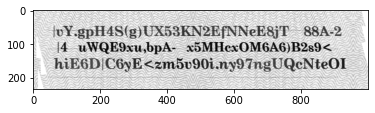

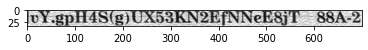

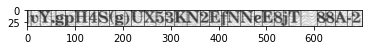

	 "/vY.gpH4S(g)UX53KN2EfNNeE8jT 88A-2"


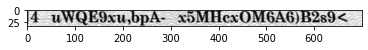

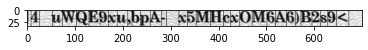

	 "/4 uWQE9xu,bpA- x5MHcxOM6A6)B2s9< "


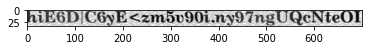

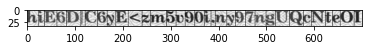

	 "hiE6D/C6yE<zm5v90i.ny97ngUQcNteOI"


In [ ]:
X_test = []
chr_str = ''
image = img_as_uint(io.imread('/gdrive/My Drive/'+filenames['train_data'][0][0], as_gray=True))
print(image.shape)
plt.figure()
plt.imshow(image, cmap='gray')
plt.show()
with open('/gdrive/My Drive/'+filenames['train_data'][0][1], 'r') as fp:
    label = json.load(fp)
for item in label:
    x, y, w, h = item['line_rect']
    sample = {}
    img_crop = image[y:y+h, x:x+w] #crop(image, ((y, y+h), (x, x+w)))
    img_crop = resize(img_crop, (33, 700))
    plt.figure()
    plt.imshow(img_crop, cmap='gray')
    plt.show()
    # print(img_crop.shape, np.max(item['cuts_x']), np.min(item['cuts_x']), x)
    
    index = (np.asarray(item['cuts_x']) - x) *699/w
    index = index.astype(int)
    # img_crop_rgb = gray2rgb(img_crop)
    for i in range(len(index)):
      if i ==0 :
        image_char = img_crop[:, 0:index[i]]
      else:
        image_char = img_crop[:, index[i-1]:index[i]]
      img_resize = resize(image_char, (15,19))
      # print(img_resize.shape)
      X_test.append(img_resize)
    for i in index:
      img_crop[:, i] = 0
      # img_crop_rgb[:, i, 0] = 255
      # img_crop_rgb[:, i, 1] = 0
      # img_crop_rgb[:, i, 2] = 0
    plt.figure()
    plt.imshow(img_crop, cmap='gray')
    plt.show()
    output = '"'
    for ch in [chr(k) for k in item['values']]:
      output += ch
      chr_str += ch
    output += '"'
    print("\t",output)


In [ ]:
X_test = np.asarray(X_test)
X_test = X_test.reshape(X_test.shape[0], 15, 19, 1)
X_test.shape

(98, 15, 19, 1)

In [ ]:

# classifier = load_model("classifierpaper_70classes-2-95.34.h5")
class_probs = np.asarray(classifier.predict(X_test))
max_scores = np.max(class_probs, axis=1)
max_scores_index = np.argmax(class_probs, axis=1)
output_str = ''
for s in max_scores_index:
#         if s in range(0,10):
#             output_str += str(s)
#         elif s in range(10, 37):
#             output_str += chr(65 + (s-10))
#         else:
#             output_str += chr(97 + (s-36))
    for k, v in label_map.items():
        if v == s:
            output_str += k
print(output_str)

/vY.gpH4S(yyUX53KN2EfNNeE8iT 88A-L4 wWQE9vu-bpn- w5MHcxOMGAGyB2s9<hiE6DLCGyE<zm5v9Oi.ny97ngUQcNteO


In [ ]:
# np.min(w_list) #min w 717

776

In [ ]:


class SegmentaionDataset(Dataset):

    def __init__(self, root_dir, dataset='train_data', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
        # for i in range(10):
        #     label_map[chr(48+i)] = 8+i
        # for i in range(26):
        #     label_map[chr(65+i)] = 18+i
        #     label_map[chr(97+i)] = 18+i

        label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
        for i in range(10):
            label_map[chr(48+i)] = 8+i
        for i in range(26):
            label_map[chr(65+i)] = 18+i
        for i in range(26):
            label_map[chr(97+i)] = 44+i

        char_list_dict = {}
        char_i= 0
        self.root_dir = root_dir 
        pkl_file = open(root_dir, 'rb')
        filenames = pickle.load(pkl_file)
        pkl_file.close()     
        self.transform = transform
        self.sample_list = []
        for _f in filenames[dataset]:
            image = img_as_uint(io.imread('/gdrive/My Drive/'+_f[0], as_gray=True))
            with open('/gdrive/My Drive/'+_f[1], 'r') as fp:
                label = json.load(fp)
            for item in label:
                x, y, w, h = item['line_rect']
                sample = {}
                img_crop = image[y:y+h, x:x+w] #crop(image, ((y, y+h), (x, x+w)))
                sample['image'] = resize(img_crop, (33, 700)).reshape(1,33,700)
                index = (np.asarray(item['cuts_x']) - x) * (699/w)
                index = ( index ).astype(int)
                x_cuts = np.zeros(700)
                if index.shape[0] > x_cuts.shape[0]:
                  print(index.shape, x_cuts.shape, (700/w))
                  print(index[0:10])
                x_cuts[index] = 1
                
                sample['landmark'] = x_cuts.reshape((1,1,700))
                char_list = [chr(val) for val in item['values']]
                sample['values'] = char_i
                char_list_dict[char_i] = char_list
                char_i += 1
                self.sample_list.append(sample)

        output = open('char_list_dict.pkl', 'wb')
        pickle.dump(char_list_dict, output)
        output.close()
                    

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.transform:
            for item in range(len(self.sample_list)):
                self.sample_list[item] = self.transform(self.sample_list[item])
        return self.sample_list[idx]


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks, val = sample['image'], sample['landmark'], sample['values']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #image = image.transpose((2, 0, 1))
        if not torch.is_tensor(image):
            image = torch.from_numpy(image)
        if not torch.is_tensor(landmarks):
            landmarks = torch.from_numpy(landmarks)
        return {'image': image,
                'landmark': landmarks, 'values': val}

val_dataset = SegmentaionDataset('/gdrive/My Drive/datasets/filenames.pkl', dataset='test_data',
                                           transform=transforms.Compose([ToTensor()]))

In [ ]:
print(len(val_dataset))
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), 
                                           sampler=sampler.SubsetRandomSampler(range(len(val_dataset))))

2190


In [ ]:
def my_custom_euclidean(x, y):
    return torch.mean(torch.sqrt(torch.sum(torch.square(x-y), dim=-1)))

class CustomActivation(nn.Module):
    def __init__(self, mean=0, std=1, _min=0.0, _max=1.0):
        super(CustomActivation, self).__init__()
        self.mean = mean
        self.std = std
        self.min = _min
        self.max = _max
        
    def forward(self, x):
        gauss = torch.exp((-(x - self.mean)**2)/(2*self.std**2))
        return torch.clamp(gauss, min=self.min, max=self.max)
    
class CustomActivation_inverse_quadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_quadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/(1 + (self.epsilon*x)**2)
    
class CustomActivation_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return torch.sqrt(1 + (self.epsilon*x)**2)
    
class CustomActivation_inverse_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/torch.sqrt(1 + (self.epsilon*x)**2)
    
def check_accuracy_part34(loader, model):   
    num_correct = 0
    num_samples = 0
    total_loss = []
    orig_ks_loss = [[], []]
    ks_loss = [[], []]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, x_y in enumerate(loader):
            x = x_y['image']
            y = x_y['landmark']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
#             loss = torch.dist(scores, y)
#             total_loss.append(loss.item())
            loss = my_custom_euclidean(scores,y)
            total_loss.append(float(loss))
            scores_numpy = scores.detach().cpu().numpy()
            scores_numpy = scores_numpy.reshape((scores_numpy.shape[0], -1))
            y_numpy = y.detach().cpu().numpy()
            y_numpy = y_numpy.reshape((y_numpy.shape[0], -1))
            for i in range(len(scores_numpy)):
                index_max = argrelextrema(scores_numpy[i], np.greater)[0]
                score_proj  = np.zeros(y_numpy[i].shape)
                score_proj[index_max] = 1
                stat, pvalue = ks_2samp(score_proj, y_numpy[i])
                ks_loss[0].append(stat)
                ks_loss[1].append(pvalue)
                stat, pvalue = ks_2samp(scores_numpy[i], y_numpy[i])
                orig_ks_loss[0].append(stat)
                orig_ks_loss[1].append(pvalue)
    print('train/val loss = %.4f' % (np.mean(np.asarray(total_loss))))
    print('ks_test (stat pvalue) = %.4f, %.4f' %(np.mean(ks_loss[0]), np.mean(ks_loss[1])))
    print('orig ks_test (stat pvalue) = %.4f, %.4f' %(np.mean(orig_ks_loss[0]), np.mean(orig_ks_loss[1])))
        
               
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# model = torch.load("segmenter_inverse_multiquadratic_distloss_700.h5")
model = torch.load("/content/segmenter_gaussian_mse_relu_700.h5")
model.eval()
check_accuracy_part34(loader_val, model)

train/val loss = 4.8701
ks_test (stat pvalue) = 0.0966, 0.0102
orig ks_test (stat pvalue) = 0.9460, 0.0000


In [ ]:

# label map if case sensitive
label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
for i in range(10):
    label_map[chr(48+i)] = 8+i
for i in range(26):
    label_map[chr(65+i)] = 18+i
for i in range(26):
    label_map[chr(97+i)] = 44+i

pkl_file = open('char_list_dict.pkl', 'rb')
char_list_dict = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('/gdrive/My Drive/datasets/fd.pkl', 'rb')
fd = pickle.load(pkl_file)
pkl_file.close()


fd_min, fd_max, fd_mean, w_h_min, w_h_max, w_h_mean = fd['fd_min'], fd['fd_max'], fd['fd_mean'], fd['w_h_min'], fd['w_h_max'], fd['w_h_mean']

# classifier = load_model("classifierpaper_synthetic.h5")
dist_list = []
dist1_list = []
len_list = []

dist_list1 = []
dist1_list1 = []
len_list1 = []

dist_list2 = []
dist1_list2 = []
len_list2 = []

_fd_min = np.floor(np.mean(fd_min))
_fd_max = np.ceil(np.mean(fd_max))
_fd_mean = np.mean(fd_mean) #[18.18]

#predict cuts
with torch.no_grad():
    for t, x_y in enumerate(loader_val):
        x = x_y['image']
        y = x_y['landmark']
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.float32)
        char_val = x_y['values']
        scores_test = model(x)
batch_size, _, ht, wd = x.size()
#convert to numpy
scores_temp = scores_test.cpu().detach().numpy()
scores_temp = scores_temp.reshape((batch_size, -1))

images = x.detach().cpu().detach().numpy()
images = images.reshape((batch_size,ht,wd))
#actual result
scores_actual = y.detach().cpu().detach().numpy()
scores_actual = scores_actual.reshape((scores_actual.shape[0], -1))
for i in range(batch_size):
    image_example = images[i]
    score_example = scores_temp[i]
    
    index_actual = np.where(scores_actual[i]==1)[0]
    # print(np.sum(scores_actual[100]))
    char_list = char_list_dict[int(char_val[i])]
    # orig str
    char_str = ''
    for c in char_list:
        char_str += c

    #local maxima indices
    index_P = argrelextrema(score_example, np.greater)[0] #index of local maxima
    index_P_01 = np.zeros(score_example.shape) 
    index_P_01[index_P] = 1 


    #dist between left and right index of cuts
    #len(index_P)xlen(index_P)
    dist = pairwise_distances(np.asarray(index_P).reshape(-1,1), metric='manhattan') 
    #index pairs such that width is betwwen fd-min and fd-max
    l, r = np.where((dist>= np.min(fd_min)) & (dist<= np.min(fd_max)))
    # l, r = np.where((dist/33>= np.min(w_h_min)) & (dist/33<= np.min(w_h_max)))
    #top m = img_width/mean_char_width choices
    l_r = []

    for j in range(len(l)):
        if l[j] < r[j] and (index_P[int(r[j])] - index_P[int(l[j])])/33 >= np.mean(w_h_min) and (index_P[int(r[j])] - index_P[int(l[j])])/33 <= np.mean(w_h_max):
            try:
                l_r.append([ index_P[int(l[j])], index_P[int(r[j])], 
                                     score_example[index_P[int(l[j])]] + score_example[index_P[int(r[j])]] ])
            except TypeError:
                print("AAH", l[j], r[j], len(index_P), )

    # l_r = l_r[l_r[:,2].argsort()] #sort according to P(l) +P(r)
    l_r_sorted = sorted(l_r, key = itemgetter(2), reverse=True)

    char_images = []
    #top m choices
    for i in range(len(l_r)): # #np.mean(fd_mean))):
        if l_r[i] in l_r_sorted[0:int(700/np.mean(fd_mean))]:
            img_crop = image_example[:, l_r[i][0]: l_r[i][1]]
            img_bin = resize(img_crop, (15,19))
            char_images.append(img_bin)
    
    if len(char_images) == 0:
      continue
    X_test = np.asarray(char_images)
    X_test = X_test.reshape((X_test.shape[0], 15, 19, 1))
    class_probs = np.asarray(classifier.predict(X_test))
    max_scores = np.max(class_probs, axis=1)
    max_scores_index = np.argmax(class_probs, axis=1)
    output_str = ''
    for i in range(len(max_scores_index)):
        # if max_scores[i] < 0.75:
        #   continue
        s = max_scores_index[i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    # print(char_str, "->", output_str)
    dist_list.append(levenshtein_distance(output_str, char_str))
    dist1_list.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list.append(len(char_str))

    output_str = ''
    for i in range(len(max_scores_index)):
        if max_scores[i] < 0.5:
          continue
        s = max_scores_index[i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    # print(char_str, "->", output_str)
    dist_list1.append(levenshtein_distance(output_str, char_str))
    dist1_list1.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list1.append(len(char_str))

    output_str = ''
    for i in range(len(max_scores_index)):
        if max_scores[i] < 0.75:
          continue
        s = max_scores_index[i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    # print(char_str, "->", output_str)
    dist_list2.append(levenshtein_distance(output_str, char_str))
    dist1_list2.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list2.append(len(char_str))
    


In [ ]:
PCR = 0
for i in range(len(dist_list)):
  PCR += min(dist_list[i], len_list[i])
PCR /= sum(len_list)
PCR = (1 - PCR) * 100

print(PCR) #test-data
print(np.mean(dist_list))
print(np.sum([dist_list[i] * len_list[i] for i in range(len(dist_list))])/ np.sum(len_list))

PCR = 0
for i in range(len(dist_list1)):
  PCR += min(dist_list1[i], len_list1[i])
PCR /= sum(len_list1)
PCR = (1 - PCR) * 100
print('0.5')
print(PCR) #test-data
print(np.mean(dist_list1))
print(np.sum([dist_list1[i] * len_list1[i] for i in range(len(dist_list1))])/ np.sum(len_list1))

PCR = 0
for i in range(len(dist_list2)):
  PCR += min(dist_list2[i], len_list2[i])
PCR /= sum(len_list2)
PCR = (1 - PCR) * 100
print('0.75')
print(PCR) #test-data
print(np.mean(dist_list2))
print(np.sum([dist_list2[i] * len_list2[i] for i in range(len(dist_list2))])/ np.sum(len_list2))

36.30338214210168
25.02420091324201
24.672197804780595
0.5
38.44101816814347
24.04200913242009
23.796307612757655
0.75
42.24269631231344
22.447488584474886
22.457776106423484


In [ ]:
# print(sum(dist1_list)/sum(len_list))
# print(np.mean(dist_list))
np.max(len_list)

67

In [ ]:
max_scores

array([0.96047205, 0.6357403 , 0.8724603 , 0.9076619 , 0.9999275 ,
       0.9062184 , 0.99963224, 0.99967706, 0.7622905 , 0.999509  ,
       0.6582342 , 0.7185718 , 0.97509015, 0.9768987 , 0.99965084,
       0.98219866, 0.6306616 , 0.48982707, 0.5735222 , 0.9990792 ,
       0.94424284, 0.97581565, 0.964107  , 0.4717945 , 0.9167646 ,
       0.7314567 , 0.99992275, 0.998645  , 0.5330241 , 0.6723378 ,
       0.97614163, 0.4896384 , 0.65109986, 0.9998087 , 0.9999949 ,
       0.58272135, 0.9156838 , 0.6782068 ], dtype=float32)

In [ ]:
#take m segments according to max (p1 + p2 +c)
dist_list = []
dist1_list = []
len_list = []
_fd_min = np.floor(np.mean(fd_min))
_fd_max = np.ceil(np.mean(fd_max))
_fd_mean = np.mean(fd_mean) #[18.18]

#predict cuts
with torch.no_grad():
    for t, x_y in enumerate(loader_val):
        x = x_y['image']
        y = x_y['landmark']
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.float32)
        char_val = x_y['values']
        scores_test = model(x)
batch_size, _, ht, wd = x.size()
#convert to numpy
scores_temp = scores_test.cpu().detach().numpy()
scores_temp = scores_temp.reshape((batch_size, -1))

images = x.detach().cpu().detach().numpy()
images = images.reshape((batch_size,ht,wd))
#actual result
scores_actual = y.detach().cpu().detach().numpy()
scores_actual = scores_actual.reshape((scores_actual.shape[0], -1))
for i in range(batch_size):
    image_example = images[i]
    score_example = scores_temp[i]
    
    index_actual = np.where(scores_actual[i]==1)[0]
    # print(np.sum(scores_actual[100]))
    char_list = char_list_dict[int(char_val[i])]
    # orig str
    char_str = ''
    for c in char_list:
        char_str += c

    #local maxima indices
    index_P = argrelextrema(score_example, np.greater)[0] #index of local maxima
    index_P_01 = np.zeros(score_example.shape) 
    index_P_01[index_P] = 1 


    #dist between left and right index of cuts
    #len(index_P)xlen(index_P)
    dist = pairwise_distances(np.asarray(index_P).reshape(-1,1), metric='manhattan') 
    #index pairs such that width is betwwen fd-min and fd-max
    l, r = np.where((dist>= np.min(fd_min)) & (dist<= np.min(fd_max)))
    #top m = img_width/mean_char_width choices
    l_r = []

    for j in range(len(l)):
        if l[j] < r[j]:
            try:
                l_r.append([ index_P[int(l[j])], index_P[int(r[j])], 
                                     score_example[index_P[int(l[j])]] + score_example[index_P[int(r[j])]] ])
            except TypeError:
                print("AAH", l[j], r[j], len(index_P), )

    # l_r = l_r[l_r[:,2].argsort()] #sort according to P(l) +P(r)
    # l_r_sorted = sorted(l_r, key = itemgetter(2), reverse=True)

    char_images = []
    #top m choices
    for i in range(len(l_r)): # #np.mean(fd_mean))):
        # if l_r[i] in l_r_sorted[0:int(700/np.mean(fd_mean))]:
        img_crop = image_example[:, l_r[i][0]: l_r[i][1]]
        img_bin = resize(img_crop, (15,19))
        char_images.append(img_bin)
    
    if len(char_images) == 0:
      continue
    X_test = np.asarray(char_images)
    X_test = X_test.reshape((X_test.shape[0], 15, 19, 1))
    class_probs = np.asarray(classifier.predict(X_test))
    max_scores = np.max(class_probs, axis=1)
    max_scores_index = np.argmax(class_probs, axis=1)
    for i in range(len(l_r)):
      l_r[i][2] /= 2
      l_r[i][2] += max_scores[i]
      l_r[i].append(max_scores_index[i])
    l_r_sorted = sorted(l_r, key = itemgetter(2), reverse=True)

    output_str = ''
    for i in range(len(l_r)):
      if l_r[i] in l_r_sorted[0:int(700/np.mean(fd_mean))]:
        s = l_r[i][3]
        for k, v in label_map.items():
          if v == s:
            output_str += k

        
    # print(char_str, "->", output_str)
    dist_list.append(levenshtein_distance(output_str, char_str))
    dist1_list.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list.append(len(char_str))
    


In [ ]:
PCR = 0
for i in range(len(dist_list)):
  PCR += min(dist_list[i], len_list[i])
PCR /= sum(len_list)
PCR = (1 - PCR) * 100

print(PCR) #test-data
print(np.mean(dist_list))
print(np.sum([dist_list[i] * len_list[i] for i in range(len(dist_list))])/ np.sum(len_list))

37.30932850729781
24.518721461187216
24.27055961642419


In [ ]:
_fd_max = np.min(fd_max)
_fd_min = np.min(fd_min)
dp_matrix = np.zeros((int(700/np.min(fd_min)), 700))
x_range = {int(700/np.min(fd_min)) : [700 - _fd_max, 700]}
for i in range(dp_matrix.shape[0]-1, 0 , -1):
  x_range[i] = [x_range[i+1][0]-_fd_max, x_range[i+1][1] - _fd_min]
# dp_matrix[0, 0: _fd_max + 1] = 0.5 * index_P[0 : _fd_max + 1]
# for k in range(1, dp_matrix.shape[0]):
#   for x>


In [ ]:
# fd_min = 2
# fd_max = 56
# fd_mean = 32
for i in range(1):
    image_example = images[i]
    score_example = scores_temp[i]
    
    # index_actual = np.where(scores_actual[i]==1)[0]
    # # print(np.sum(scores_actual[100]))
    # char_list = char_list_dict[int(char_val[i])]
    # char_str = ''
    # for c in char_list:
    #     char_str += c

    # #local maxima indices
    # index_P = argrelextrema(score_example, np.greater)[0] 
    # index_P_01 = np.zeros(score_example.shape)
    # index_P_01[index_P] = 1

    # dp = np.zeros((int(800/fd_min), 800))
    # for i in range(dp.shape[0]):
    #   if i == 0:
    #     dp[i, 0 : fd_max] = 0.5 * score_example[0 : fd_max]
    #   else:
    #     candidate_characters = []
    #     for j in range(fd_max, dp.shape[1]):
    #       if dp[i-1, j-fd_max] == 0.0:
    #         break
    #       prev_cut = np.argmax(dp[i-1, j-fd_max : j-fd_min]) + (j-fd_max)
    #       dp[i, j] = 0.5 * score_example[j] + dp[i-1, prev_cut]
    #       candidate_characters.append(resize(image_example[:, prev_cut:j], (15,19)))
    #     X_test=np.asarray(candidate_characters)
    #     X_test = X_test.reshape((X_test.shape[0], 15, 19, 1))
    #     class_probs = np.asarray(classifier.predict(X_test))
    #     max_classifier_scores = np.max(class_probs, axis=1)
    #     k=0
    #     for j in range(fd_max, dp.shape[1]):   
    #       if dp[i-1, j-fd_max] == 0.0:
    #         break
    #       dp[i,j] += max_classifier_scores[k]
    #       k += 1

    dp = [[np.argmax(score_example[0:fd_max]), 0.5*max(score_example[0:fd_max])]]
    for k in range(1, int(800/18.18)):
        dp_temp = {}
        candidate_characters = []
        print(dp[k-1][0]+fd_min, dp[k-1][0]+fd_min+fd_max)
        for x in range(dp[k-1][0]+fd_min, dp[k-1][0]+fd_min+fd_max+1):
            dp_temp[x] = dp[k-1][1] + 0.5*score_example[x] 
            candidate_characters.append(resize(image_example[:, dp[k-1][0]:x], (28,28)))
        X_test=np.asarray(candidate_characters)
        X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
        class_probs = np.asarray(classifier.predict(X_test))
        max_classifier_scores = np.max(class_probs, axis=1)
        x = dp[k-1][0]+fd_min
        for i in range(max_classifier_scores.shape[0]):
            dp_temp[x] += max_classifier_scores[i]
        x_new, val = max(dp_temp.items(), key=itemgetter(1))
        dp.append([x_new, val])